# How to remove scattered light from TESS data using the `RegressionCorrector`?


Lightkurve offers several tools to the community for **removing instrument noise and systematics** from data from the Kepler, K2 and TESS missions. This tutorial will demonstrate the use of Lightkurve's new `RegressionCorrector` class to remove the scattered light and spacecraft motion noise from TESS Full Frame Images (FFIs).

TESS FFIs have an additive scattered light background that has not been removed by the pipeline. This scattered light must be removed by the user. This can be done in a few ways, including a simple median subtraction. In this tutorial, we'll show you how to use *Lightkurve*'s corrector tools to remove the scattered light. 

## 1. Using `RegressionCorrector` on TESSCut FFI cutouts

For this tutorial we will use the TESS Sector 15 data of [KIC 8462852](https://en.wikipedia.org/wiki/Tabby%27s_Star) (also known as Boyajian's Star).
We'll start by downloading the FFI data using MAST's *TESSCut* service, querying it through *Lightkurve*.

In [1]:
import lightkurve as lk

In [2]:
target = 'KIC 8462852'  # Boyajian's Star
tpf = lk.search_tesscut(target, sector=15).download(cutout_size=(50, 50))

In [3]:
tpf

TessTargetPixelFile(TICID: KIC 8462852)

This cut out works the same as any *Lightkurve* Target Pixel file (see our full tutorial on working with such data products [here](https://docs.lightkurve.org/tutorials/01-target-pixel-files.html)).

*TESS* FFI cut outs do not have aperture masks created by the pipeline. Instead, users must create their own apertures. There are many methods we could use to do this, but for now we can simply use a threshold aperture, using *Lightkurve*'s `create_threshold_mask()` method.

In [4]:
aper = tpf.create_threshold_mask()

Let's plot the aperture, to make sure it selected the star in the center and has a reasonable number of pixels.

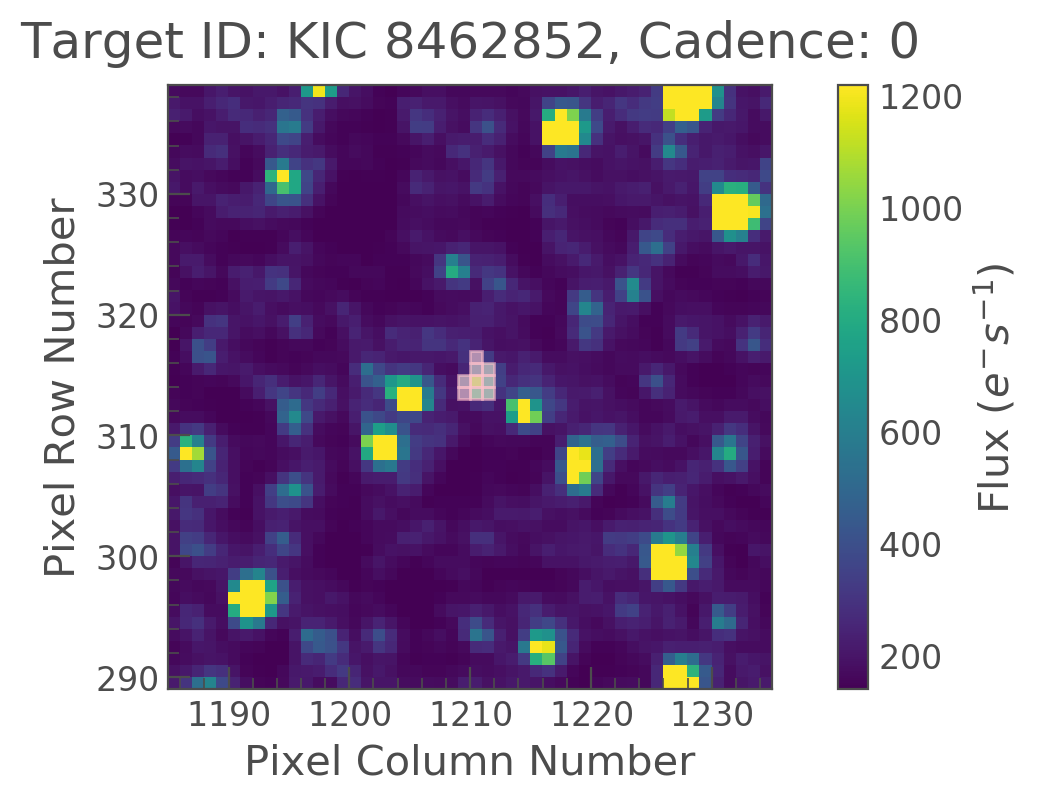

In [5]:
tpf.plot(aperture_mask=aper);

Looks good. We can sum up the pixels in this aperture, and create an uncorrected ("raw") light curve.

In [6]:
raw_lc = tpf.to_lightcurve(aperture_mask=aper)

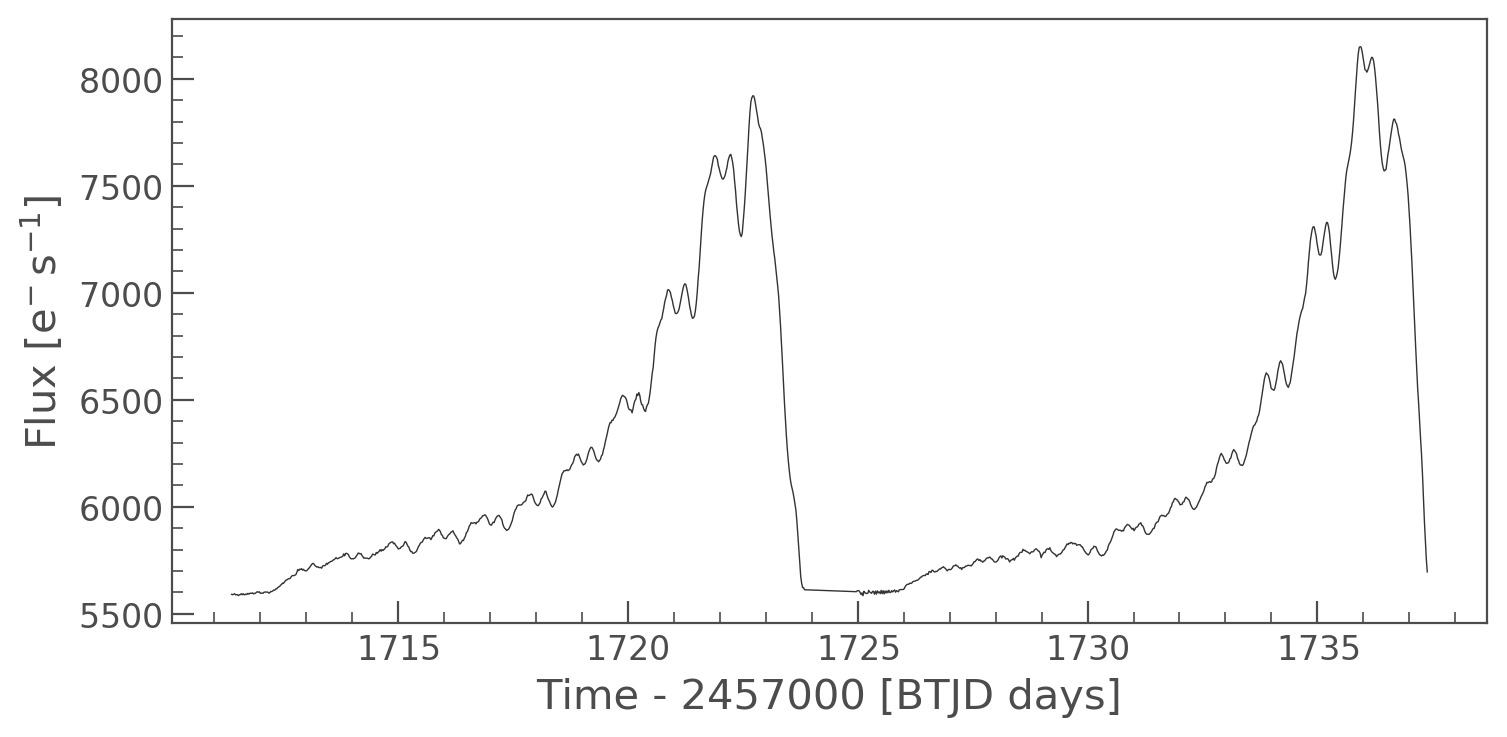

In [7]:
raw_lc.plot();

The flux in the aperture appears to be dominated by scattered light. We can tell because TESS orbits Earth twice in each sector, thus patterns which appear twice within a Sector are typically related to TESS' orbit (such as the scattered light effect).

To remove this light, we are going to *detrend* the light curve against some *vectors* which we think are predictive of this systematic noise.

In this case, we can use the **pixels outside the aperture** as vectors that are highly predictive of the systematic noise, i.e. we will make the assumption that these pixels do not contain any flux from our target.

We can select these pixels very simply by specifying flux outside the aperture using Python's bitwise invert operator `~` to take the inverse of the aperture mask.

In [8]:
regressors = tpf.flux[:, ~aper]

In [9]:
regressors.shape

(1190, 2491)

`regressors` is now an array with shape *ntime* x *npixels outside of the aperture*. If we plot the first 30 of these pixels, we can see that they contain mostly scattered light, with some offset terms.

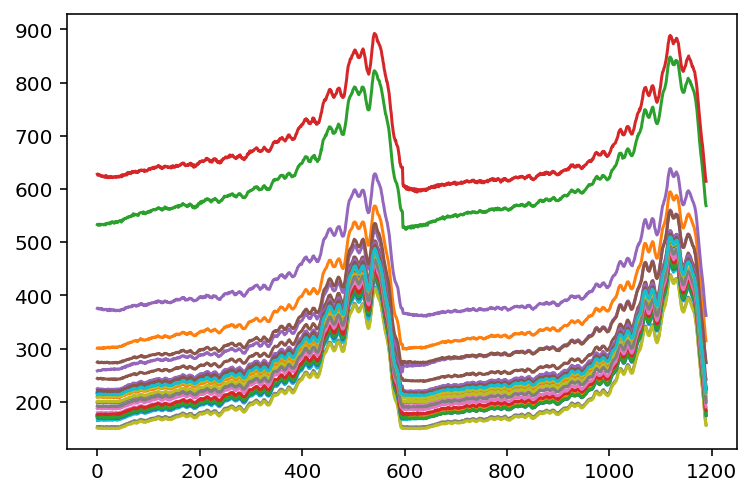

In [10]:
import matplotlib.pyplot as plt
plt.plot(regressors[:, :30]);

In linear regression problems, it is commong to refer to the matrix of regressors as the *design matrix* (also known as *model matrix* or *regressor matrix*). Lightkurve provides a convenient `DesignMatrix` class which is designed to help you work with detrending vectors. 

The `DesignMatrix` class has several convenience functions, and can be passed into *Lightkurve*'s corrector objects. Please consult the [DesignMatrix page](../api/lightkurve.correctors.DesignMatrix.html) in the API docs for the full details on the methods and features provided by this class.

In [11]:
dm = lk.DesignMatrix(regressors, name='regressors')

In [12]:
dm

regressors DesignMatrix (1190, 2491)

As shown above, `dm` is now a design matrix with the same shape as the input pixels. Currently, we have 2541 pixels that we are using to detrend our light curve against. Rather than using all of the pixels, we can reduce these to their **principal components** using **Principal Component Analysis** (PCA). We do this for several reasons:

1. By reducing to a smaller number of vectors, we can remove some of the stochastic noise in our detrending vectors.
2. By reducing to the principal components, we can avoid pixels that have intrinsic variability (e.g. from astrophysical long period variables) that can be confused with the true astrophysical signal of our target.
3. By reducing the number of vectors, our detrending will be faster, (although in this case, this detrending will still take seconds.)

The choice of the number of components is a tricky issue, but in general you should choose a number that is much smaller than the number of vectors.

In [13]:
dm = dm.pca(5)

In [14]:
dm

regressors DesignMatrix (1190, 5)

Using the `pca()` method, we have now reduced the number of components in our design matrix to 5. These vectors show a combination of scattered light and spacecraft motion, which makes them suited to detrend our input light curve.

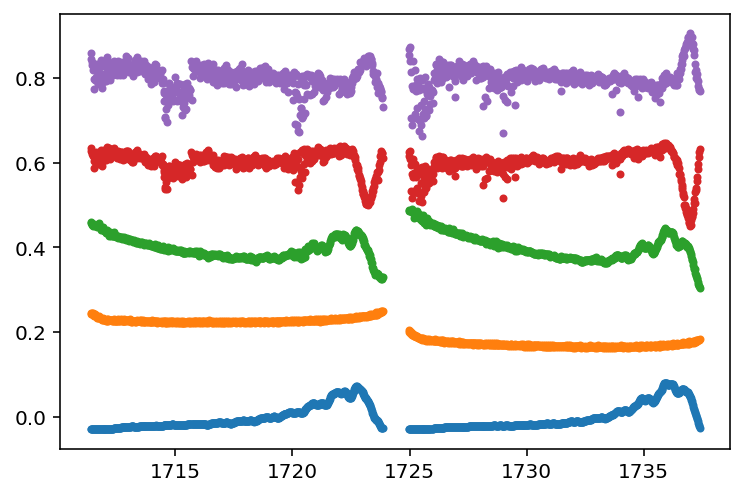

In [15]:
import numpy as np
plt.plot(tpf.time, dm.values + np.arange(5)*0.2, '.');

Note: the `DesignMatrix` object provides a convenient `plot()` method to visualize the vectors:

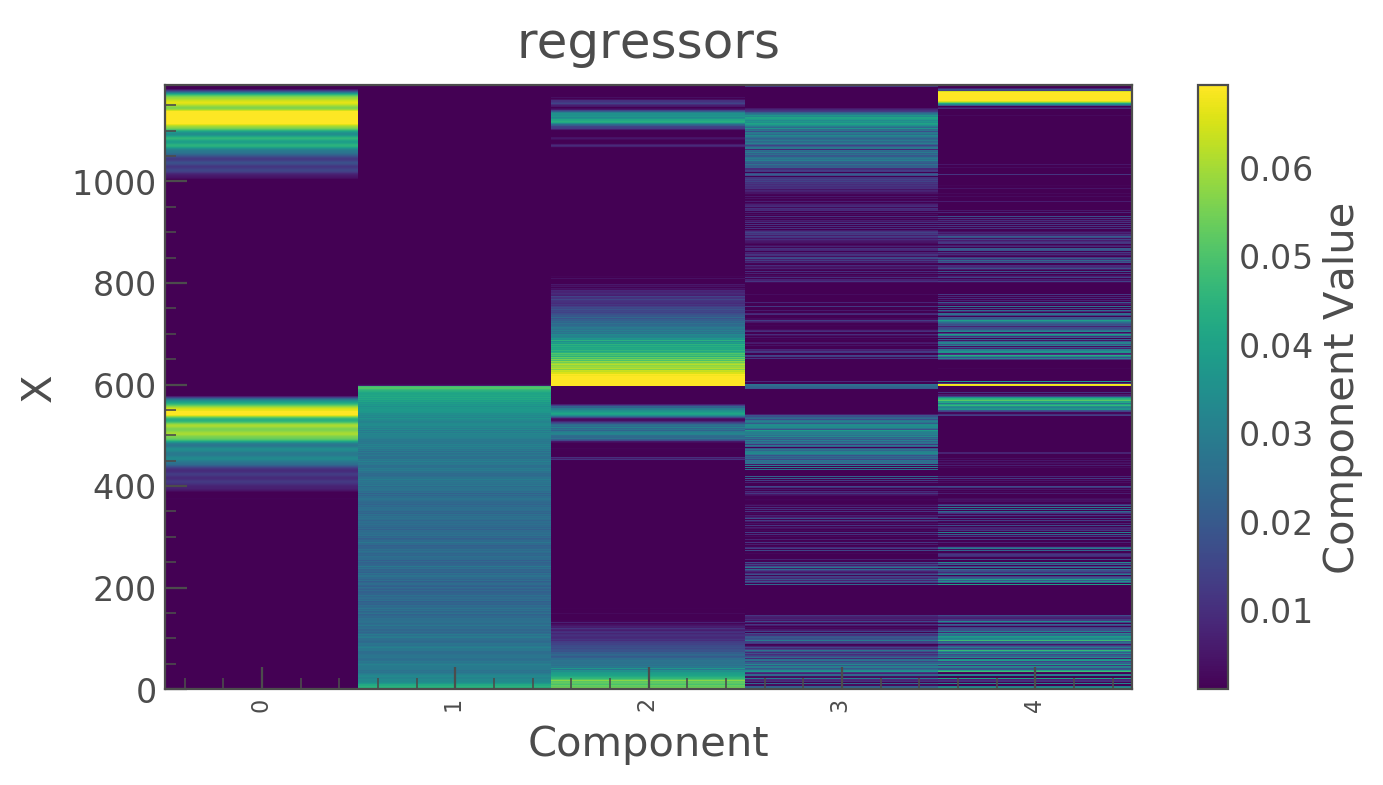

In [16]:
dm.plot();

We can now detrend the raw light curve against these vectors. *Lightkurve*'s `RegressionCorrector` will use linear algebra to find the combination of vectors that makes the input light curve **closest to zero**. To do this, we need one more component; we need an "offset" term, to be able to fit the mean level of the light curve. We can do this by appending a "constant" to our design matrix.

In [17]:
dm = dm.append_constant()

In [18]:
dm

regressors DesignMatrix (1190, 6)

Now that we have a design matrix, we only need to pass it into a `lightkurve.Corrector`. To use our design matrix, we can pass it to the `RegressionCorrector`, which will detrend the input light curve against the vectors we've built.

Please consult the [RegressionCorrector page](../api/lightkurve.correctors.RegressionCorrector.html) in the API docs for the full details on the methods and features provided by this class.

In [19]:
corrector = lk.RegressionCorrector(raw_lc)

In [20]:
corrector

RegressionCorrector (ID: KIC 8462852)

To correct the light curve, we simply pass in our design matrix.

In [21]:
corrected_lc = corrector.correct(dm)

Now we can plot the results

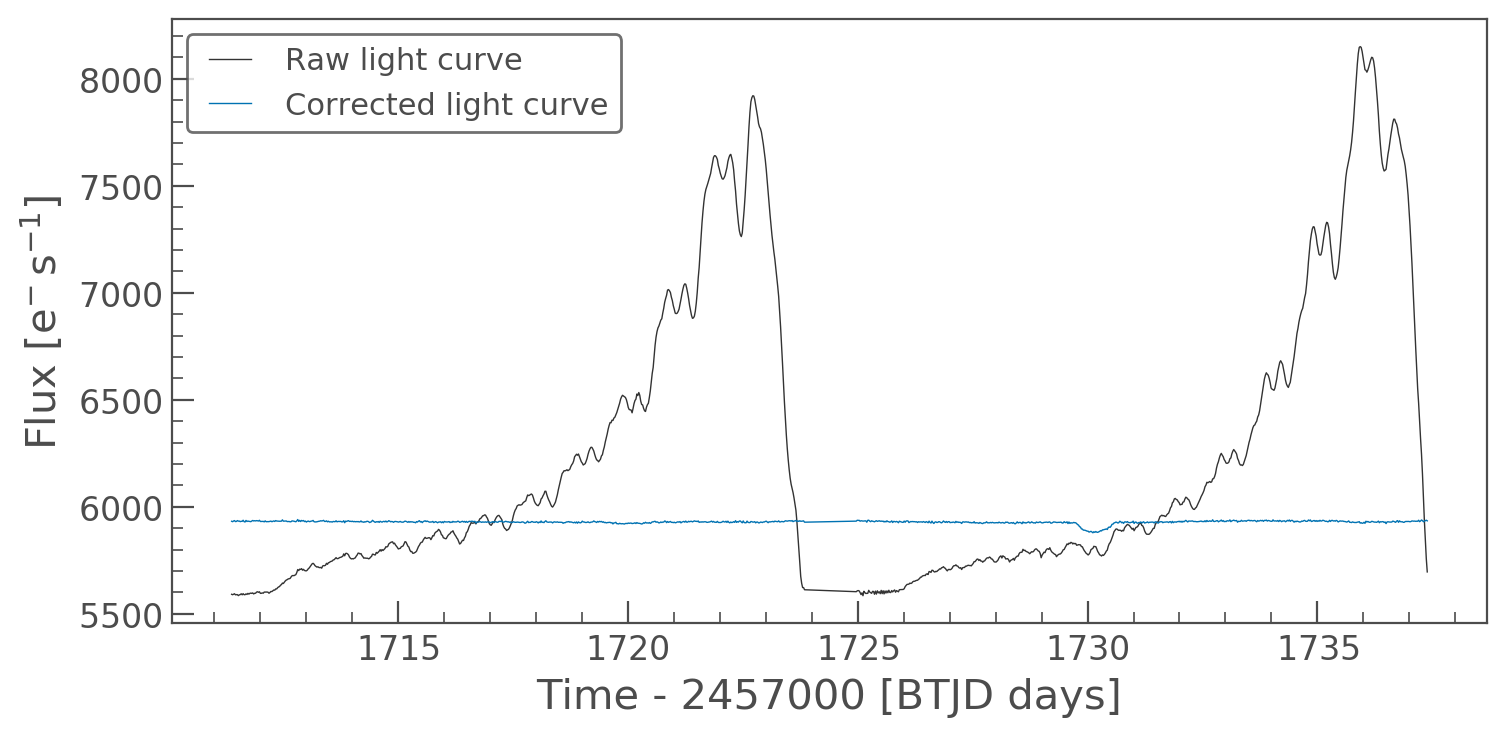

In [22]:
ax = raw_lc.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

As shown above, the scattered light from the background has been removed. If we want to see a more in depth look at the correction, we can use the `diagnose()` method to see what the `RegressionCorrector` found as the best fitting solution.

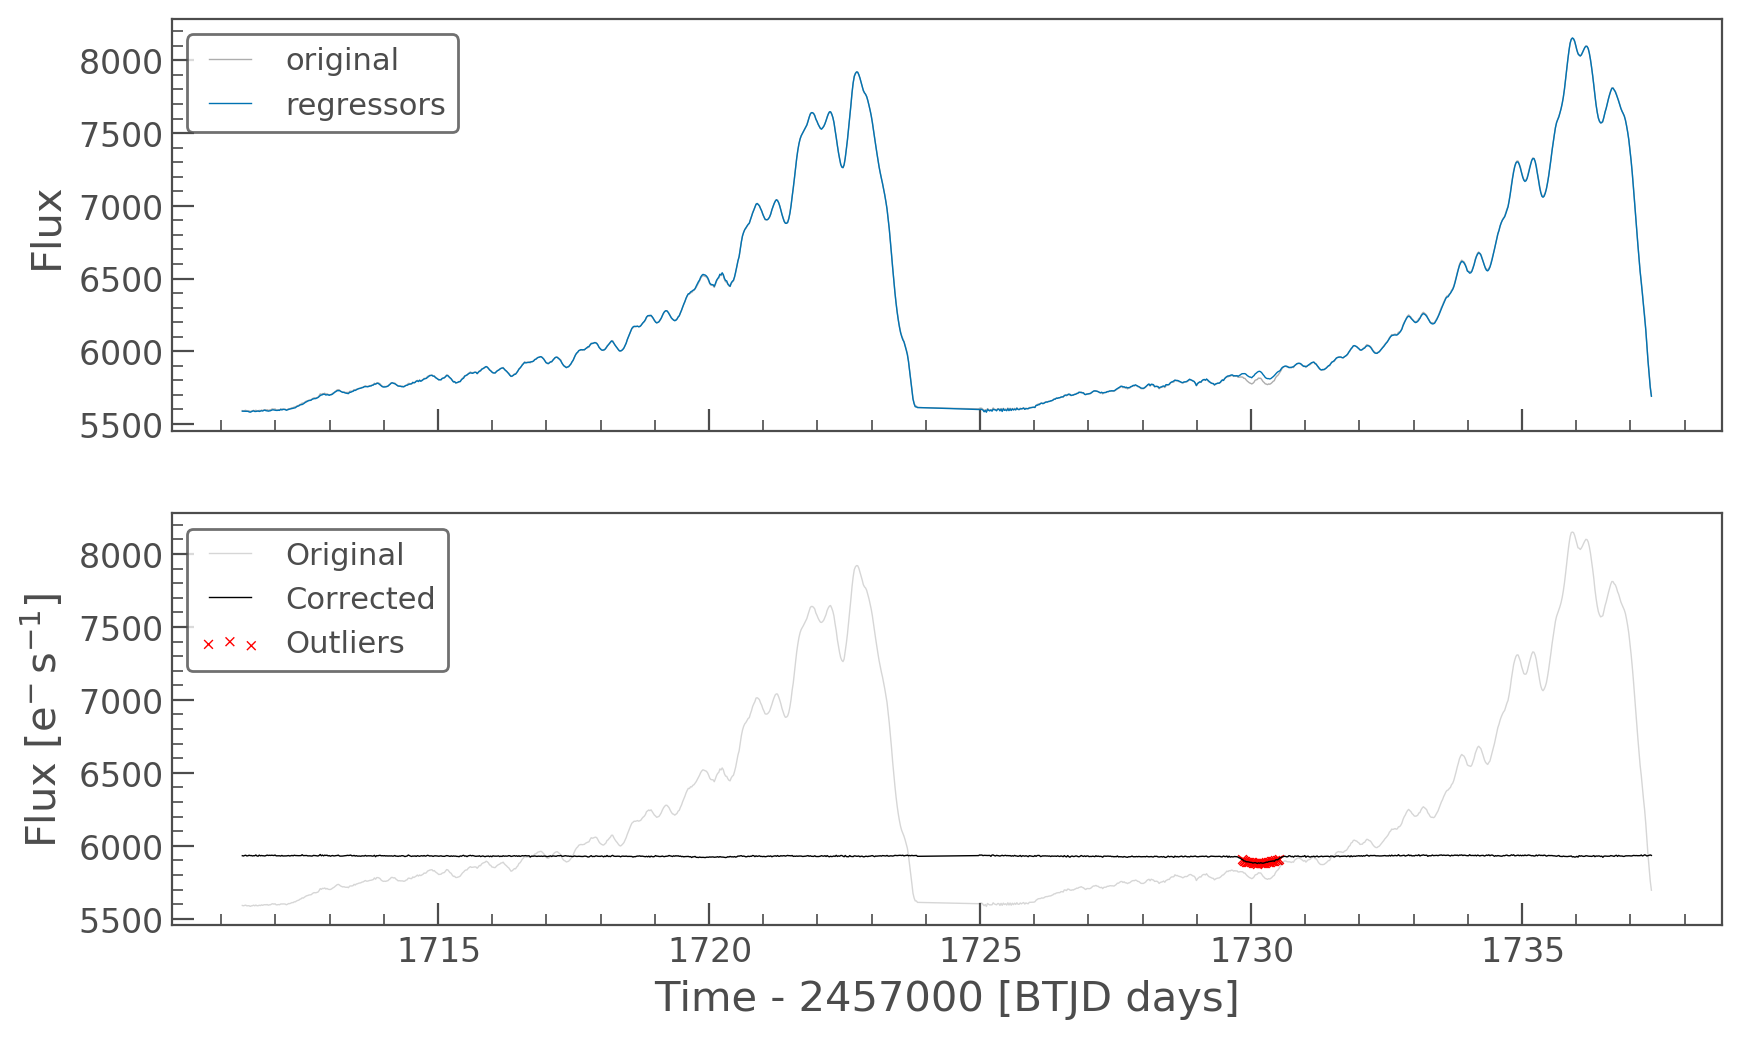

In [23]:
corrector.diagnose();

Regression corrector has clipped out some outliers during the fit of the trend. You can read more about the outlier removal, how to pass a cadence mask, and error propagation in our [docs](https://docs.lightkurve.org/api/lightkurve.correctors.RegressionCorrector.html#lightkurve.correctors.RegressionCorrector).

**Watch Out!**

The `RegressionCorrector` assumes that you want to remove the trend and set the lightkurve to the **mean** level of the **raw lightkurve**. This isn't true for TESS scattered light. TESS FFI light curves have **additive background**, and so we want to reduce the flux to the lowest recorded level, assuming that at that point the contribution from scattered light is approximately zero.

To do this, we will first need to look at the *model* of the background that `RegressionCorrector` built. We can access that in the `corrector` object.

In [24]:
corrector.model_lc

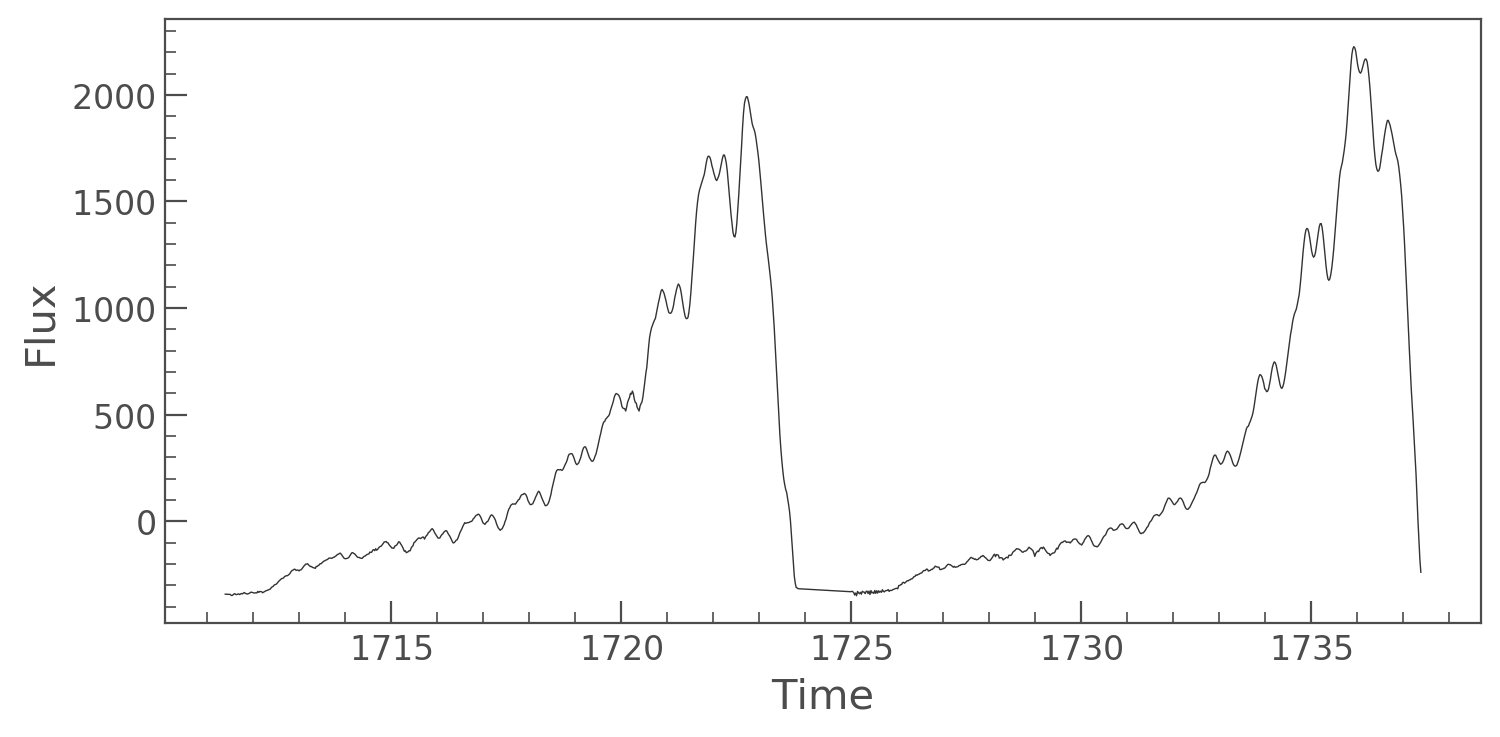

In [25]:
model = corrector.model_lc
model.plot();

As you can see above, the *model* drop below zero flux. This is impossible; the scattered light can't be **removing** flux from our target! 

To rectify this, we can subtract the model flux value at the 5th percentile.

In [26]:
# Normalize to the 5th percentile of model flux
model -= np.percentile(model.flux, 5)

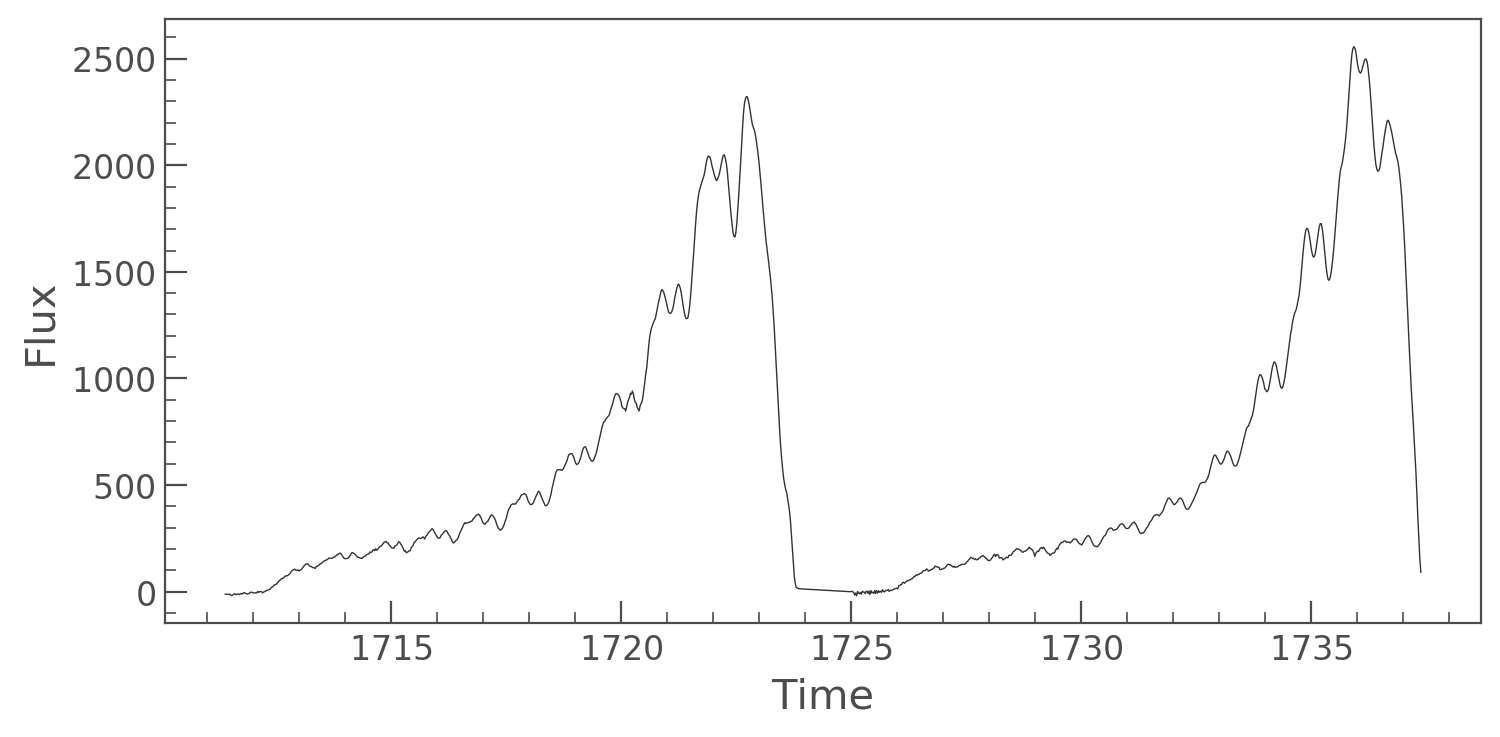

In [27]:
model.plot();

This looks better. Now we can simply remove this model from our raw light curve.

In [28]:
corrected_lc = raw_lc - model

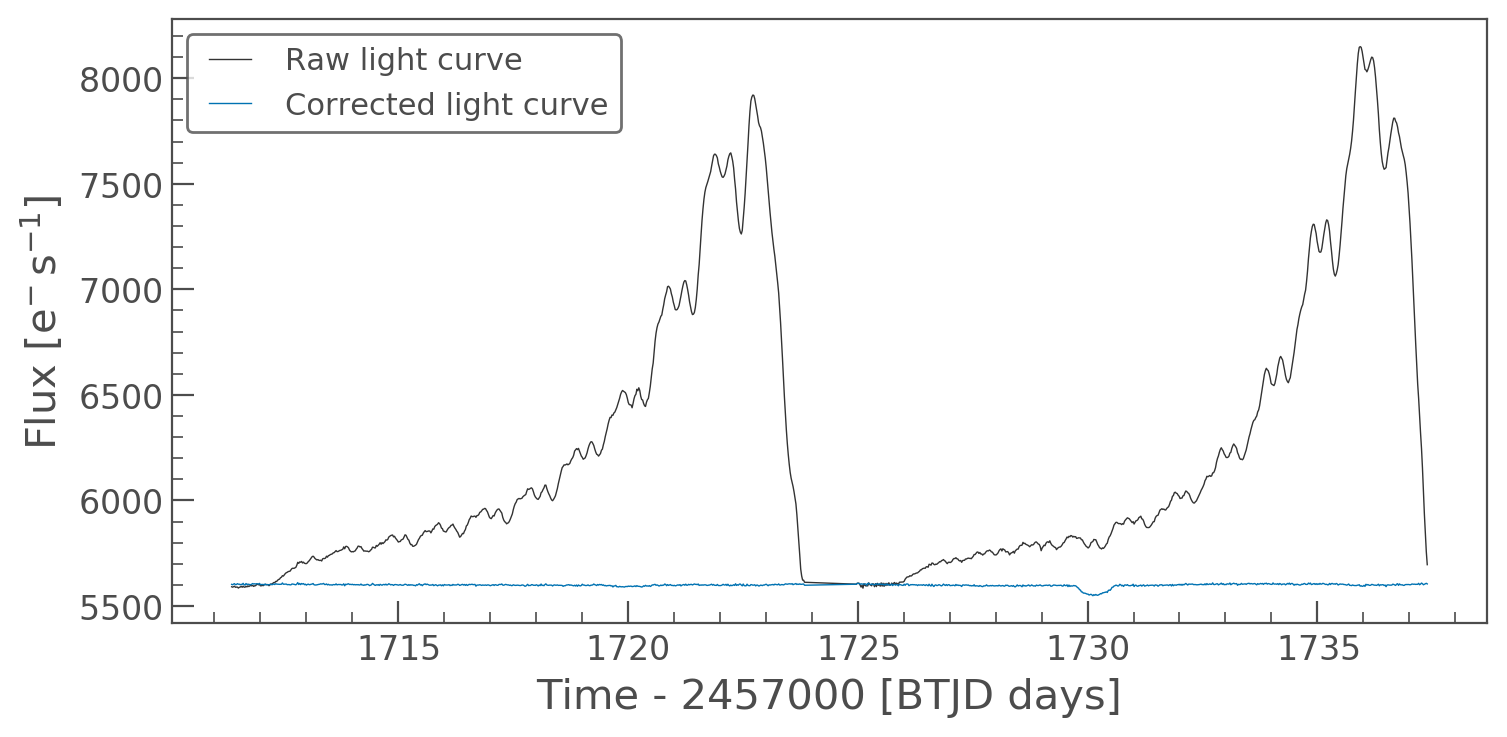

In [29]:
ax = raw_lc.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

This looks great. As a final test, let's investigate how the light curve we obtained using `RegressionCorrector` compares against a light curve obtained using a more simple median background removal method.

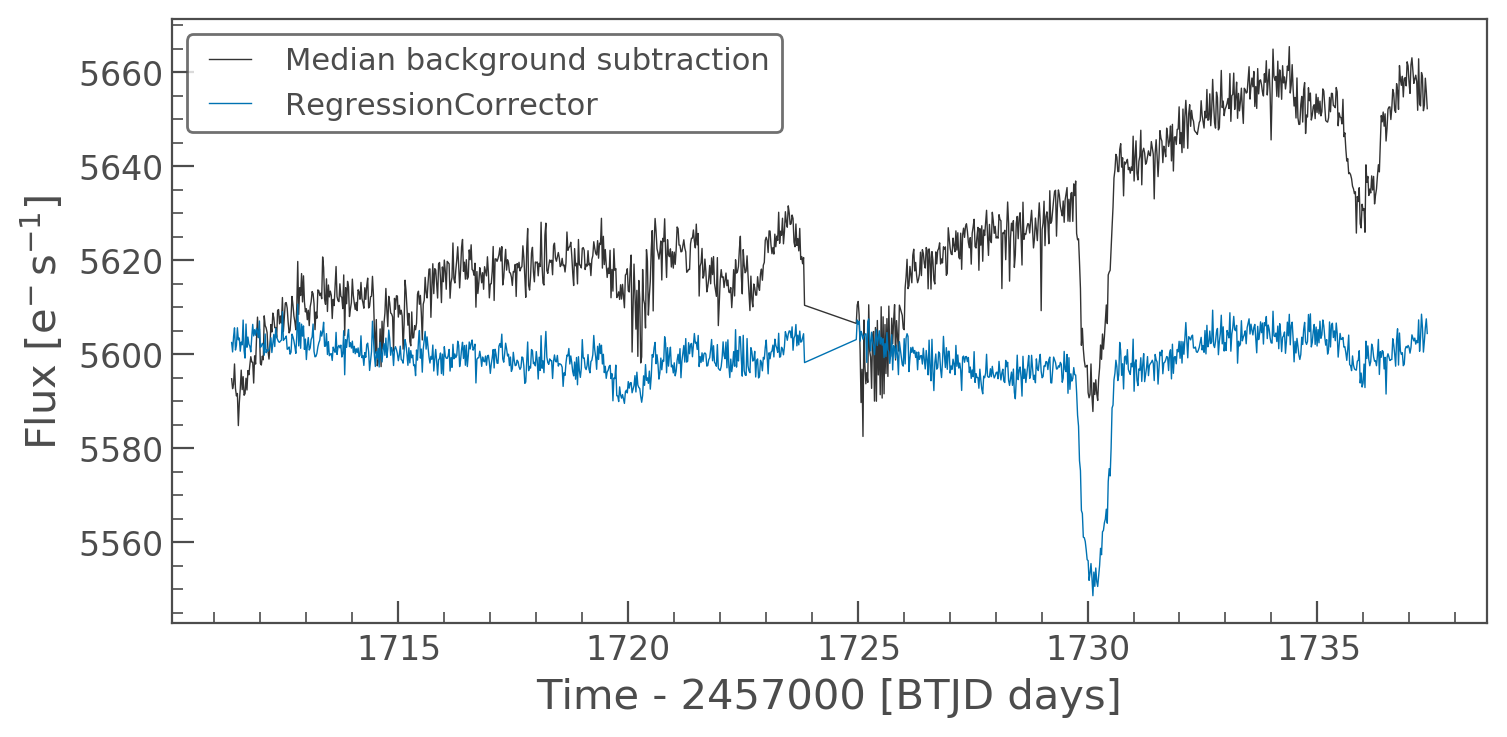

In [30]:
bkg = np.median(regressors, axis=1)
bkg -= np.percentile(bkg, 5)

npix = aper.sum()
median_subtracted_lc = raw_lc - npix * bkg

ax = median_subtracted_lc.plot(label='Median background subtraction')
corrected_lc.plot(ax=ax, label='RegressionCorrector');

Lastly, lets show how you can do all of the above in a single cell.

In [31]:
# Make an aperture mask and a raw light curve
aper = tpf.create_threshold_mask()
raw_lc = tpf.to_lightcurve(aperture_mask=aper)

# Make a design matrix and pass it to a linear regression corrector
dm = lk.DesignMatrix(tpf.flux[:, ~aper], name='regressors').pca(5).append_constant()
rc = lk.RegressionCorrector(raw_lc)
corrected_lc = rc.correct(dm)

# Optional: Remove the scattered light, allowing for the large offset from scattered light
corrected_lc = raw_lc - rc.model_lc + np.percentile(rc.model_lc.flux, 5)

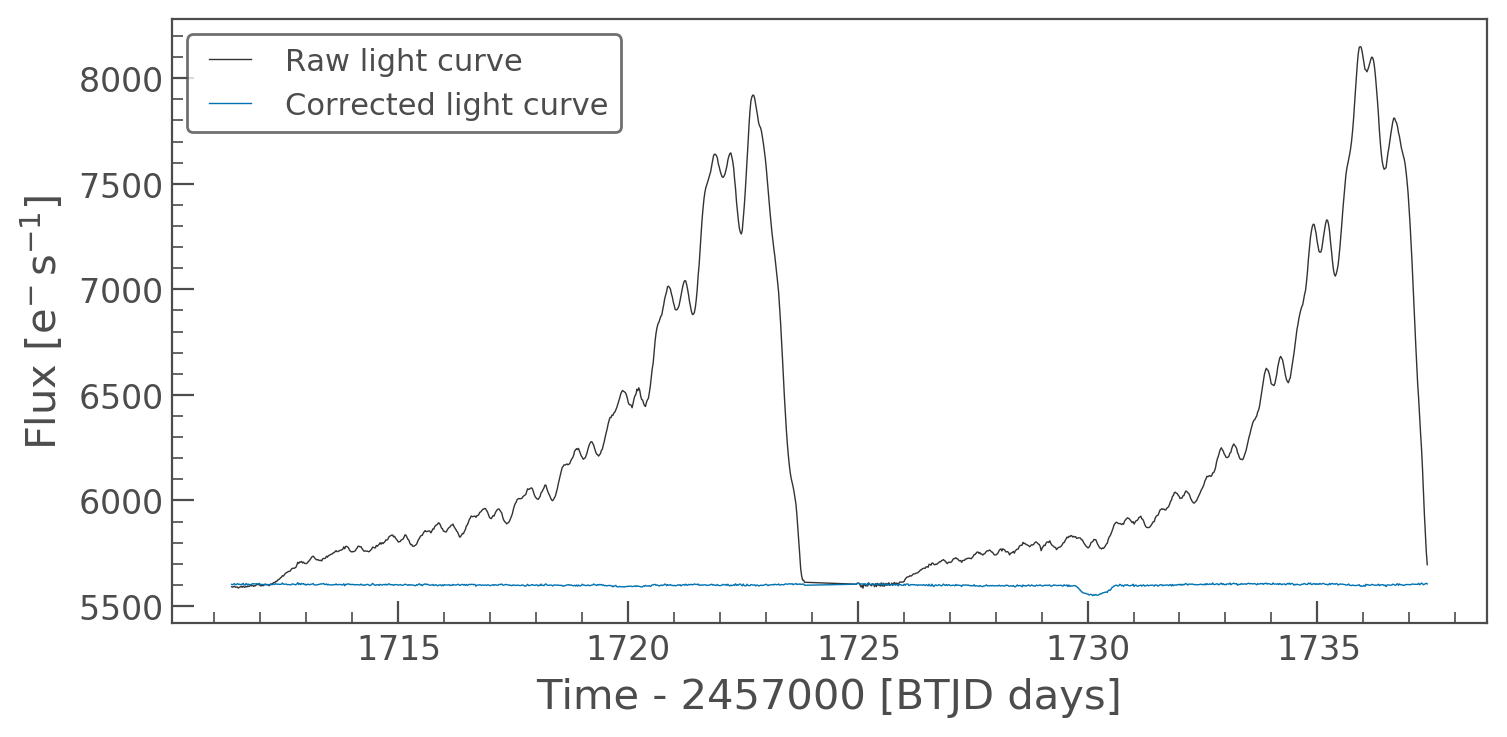

In [32]:
ax = raw_lc.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

## 2. Using `RegressionCorrector` on TESS 2-minute cadence Target Pixel Files

*TESS* releases high time resolution TPFs of interesting targets. These higher time resolution TPFs have background removed for users by the pipeline. However, there are still common trends in TPF pixels that are not due to scattered light, e.g. from spacecraft motion.

`RegressionCorrector` can be used in exactly the same way to remove these common trends.

In [33]:
# Download a 2-minute cadence Target Pixel File (TPF)
tpf_2min = lk.search_targetpixelfile(target, mission='TESS', sector=15).download()

In [34]:
tpf_2min

TessTargetPixelFile(TICID: 185336364)

Note, unlike the FFI data, the TPF has been processed by the pipeline, and includes an aperture mask.

In [35]:
# Use the pipeline aperture and a raw light curve
aper = tpf_2min.pipeline_mask
raw_lc = tpf_2min.to_lightcurve()

# Make a design matrix
dm = lk.DesignMatrix(tpf_2min.flux[:, ~aper], name='pixels').pca(5).append_constant()

# Regression Corrector Object
reg = lk.RegressionCorrector(raw_lc)
corrected_lc = reg.correct(dm)

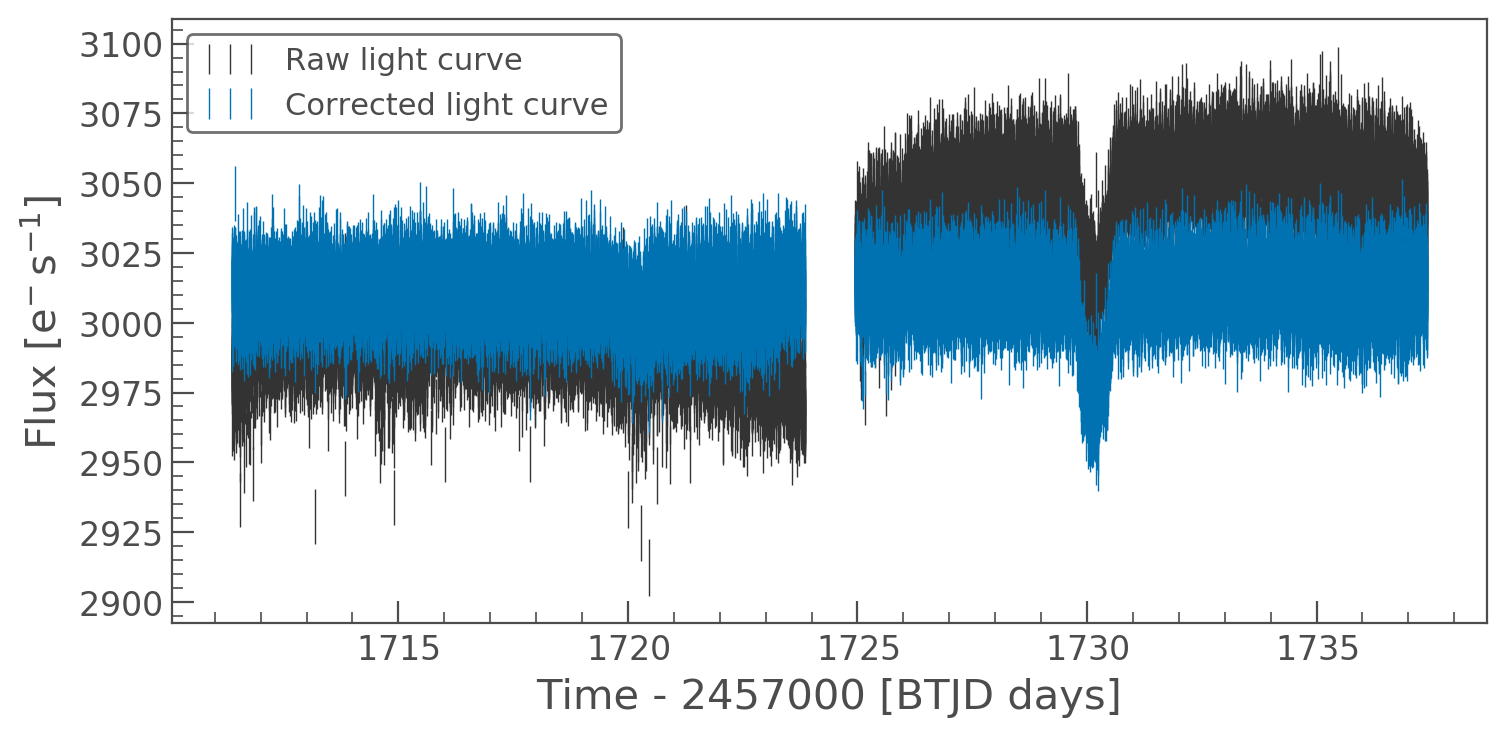

In [36]:
ax = raw_lc.errorbar(label='Raw light curve')
corrected_lc.errorbar(ax=ax, label='Corrected light curve');

As you can see the corrected light curve has removed long term trends, and some motion noise (e.g. see time around 1720 BTJD). We can use the same `diagnose()` method to understand the model that has been fit and subtracted by `RegressionCorrector`.

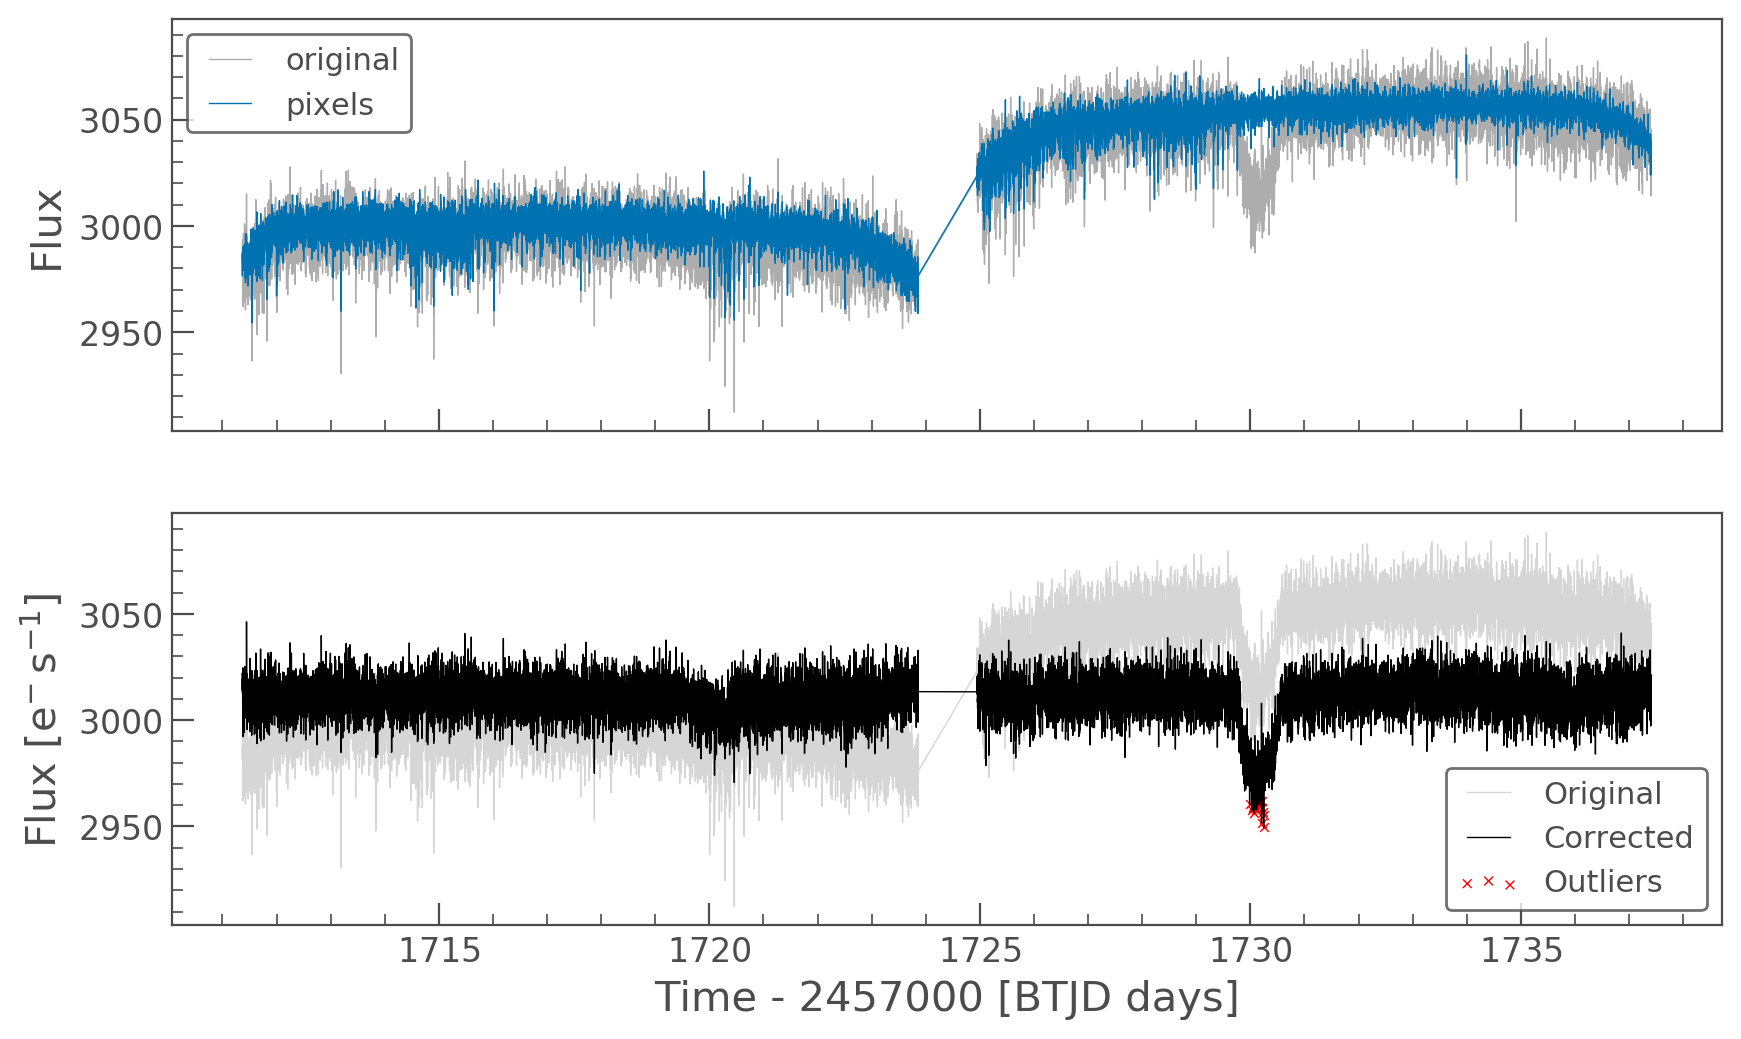

In [37]:
reg.diagnose();

To show the corrected version has improved, we can use the *CDPP* metric. As shown below, the corrected light curve has a lower *CDPP*, showing it is less noisy.

In [38]:
raw_lc.estimate_cdpp()

897.0934061715499

In [39]:
corrected_lc.estimate_cdpp()

836.8828675392166

## Further reading

* [RegressionCorrector API](../api/lightkurve.correctors.RegressionCorrector.html)
* [DesignMatrix API](../api/lightkurve.correctors.DesignMatrix.html)